In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

from DataLoader.DataLoader import DataLoader
from DataLoader.DataBasedAgent import DataBasedAgent
from DataLoader.DataRLAgent import DataRLAgent
import DeepRLAgent.VanillaInput.Train as Train
from PatternDetectionInCandleStick.Evaluation import Evaluation
import distinctipy
import plotly.graph_objs as go
from kaleido.scopes.plotly import PlotlyScope

from importlib import reload
import shutil

Train = reload(Train)
DeepRL = Train.Train
from utils_best_arm import add_train_portfo, add_test_portfo, plot_return, calc_return, plot_action_point, setup_logger
pd.options.display.max_colwidth = 100

device = "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CURRENT_PATH = os.getcwd()
plt.rcParams["font.size"] = 14

In [2]:
# # NOTE: 把profit_5的pkl文件拿过来
# symbols = os.listdir("./Data/")[:10]
# models = ["model_profit_0", "model_regularized_0.01", "model_regularized_0.05", "model_regularized_0.1", "model_regularized_0.2"]
# for symbol in symbols:
#     for seed in range(100):
#         if not os.path.exists(f"./Results/{symbol}/"):
#             os.mkdir(f"./Results/{symbol}")
#             os.mkdir(f"./Results/{symbol}/2016-01-01~2019-01-01")
#         if not os.path.exists(f"./Results/{symbol}/2016-01-01~2019-01-01/{seed}"):
#             os.mkdir(f"./Results/{symbol}/2016-01-01~2019-01-01/{seed}")
#             os.mkdir(f"./Results/{symbol}/2016-01-01~2019-01-01/{seed}/train")

#         for model in models:
#             src = f"../try7_with_regularizezd_rewards_exp3/Results/{symbol}/2016-01-01~2019-01-01/{seed}/train/{model}_{seed}.pkl"
#             dst = f"./Results/{symbol}/2016-01-01~2019-01-01/{seed}/train/{model}_{seed}.pkl"
#             shutil.copy(dst=dst, src=src)

In [3]:
def plot_action_point(dataTest_agent, data_loader, symbol, name, begin=0, end=120):

    data_test = dataTest_agent
    df1 = data_loader.data_test_with_date[begin:end]

    actionlist = list(data_test.data[data_test.action_name][begin:end])
    df1[data_test.action_name] = actionlist

    buy = df1.copy()
    sell = df1.copy()
    none = df1.copy()

    # NOTE 应该画在close处比较合适吧
    buy['action'] = [c if a == 'buy' else None for a, o, c in zip(df1[data_test.action_name], df1.open, df1.close)]
    sell['action'] = [c if a == 'sell' else None for a, o, c in zip(df1[data_test.action_name], df1.open, df1.close)]
    none['action'] = [c if a == 'None' else None for a, o, c in zip(df1[data_test.action_name], df1.open, df1.close)]

    data=[
        go.Candlestick(x=df1.index, open=df1['open'], high=df1['high'], low=df1['low'], close=df1['close'], increasing_line_color= 'lightgreen', decreasing_line_color= '#ff6961'),
        go.Scatter(x=df1.index, y=buy.action, mode = 'markers', marker=dict(color='red', colorscale='Viridis'), name="buy"), 
        go.Scatter(x=df1.index, y=none.action, mode = 'markers', marker=dict(color='blue', colorscale='Viridis'), name="hold"), 
        go.Scatter(x=df1.index, y=sell.action, mode = 'markers', marker=dict(color='green', colorscale='Viridis'), name="sell")
    ]

    layout = go.Layout(
        autosize = False,
        width = 1000,
        height = 400,
        margin=dict(l=20, r=20, t=20, b=20),
        xaxis_rangeslider_visible=False,
        xaxis_title = "date",
        yaxis_title = "adjusted close",
        font = {
            "size": 18,
        }
    )
    
    figSignal = go.Figure(data=data, layout=layout)
    figSignal.show()
    # scope = PlotlyScope()
    # with open(f"./ActionsPlot/{symbol}-{name}.png", "wb") as f:
    #     f.write(scope.transform(figSignal, format="png", scale=2))


In [4]:
def train(
    DATASET_NAME, 
    split_point='2018-01-01', 
    begin_date='2010-01-01', 
    end_date='2020-08-24', 
    model_start_date="",
    model_end_date="",
    initial_investment=1000,
    transaction_cost=0.0001,
    load_from_file=True,
    reward_type="profit",
    seed=42, 
    state_mode=1,
    n_episodes=5,
    lamb=0.0001,
    GAMMA=0.7, 
    n_step=5, 
    BATCH_SIZE=10, 
    ReplayMemorySize=20,
    TARGET_UPDATE=5,
    window_size=None, 
    train_portfolios={},
    test_portfolios={},
    arms=[],
    show_all = False,
    ratio_threshold=0.9,
):
    data_loader = DataLoader(DATASET_NAME, split_point=split_point, begin_date=begin_date, end_date=end_date, load_from_file=load_from_file)
    
    dataTrain_agent = DataRLAgent(data_loader.data_train, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
    dataTest_agent = DataRLAgent(data_loader.data_test, state_mode, 'action_encoder_decoder', device, GAMMA, n_step, BATCH_SIZE, window_size, transaction_cost)
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    agent = DeepRL(data_loader, dataTrain_agent, dataTest_agent, 
                DATASET_NAME,  state_mode, window_size, transaction_cost,
                BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA, ReplayMemorySize=ReplayMemorySize,
                TARGET_UPDATE=TARGET_UPDATE, n_step=n_step, arms=arms)
    
    path = f"./Results/{DATASET_NAME}/{model_start_date}~{model_end_date}/{seed}/train"
    arm = arms[0]
    name = f'{arm["name"]}_{arm["lamb"]}'
    model_path = f"{path}/model_{name}_{seed}.pkl"
    agent_test = agent.test(initial_investment=initial_investment, test_type='test', model_path=model_path)
    test_portfolio = agent_test.get_daily_portfolio_value()
    test_portfolio = pd.Series(test_portfolio).pct_change(1).fillna(0).values.tolist() 
    model_name = f'DQN-stock:{DATASET_NAME}-reward:{name}-seed:{seed}'
    # plot_action_point(dataTest_agent, data_loader, DATASET_NAME, name, begin=0, end=120)
    return data_loader, {"name": model_name, "portfo": test_portfolio}


In [8]:
initial_investment = 1000


kwargs = {
    "load_from_file": True, 
    "transaction_cost": 0.0000,
    "initial_investment": initial_investment,
    "state_mode": 1,
    "GAMMA": 0.7, 
    "n_step": 5, 
    "BATCH_SIZE": 10, 
    "ReplayMemorySize": 20,
    "TARGET_UPDATE": 5,
    "window_size": None, 
    "lamb": 0.0,
}

_file = "AAPL"

_begin_date = '20{}-01-01'
_end_date = '20{}-01-01'
_split_point = '20{}-01-01' 

arms = [
    # { "name": "old_profit", "lamb": 0},
    { "name": "profit", "lamb": 0},
    { "name": "regularized", "lamb": 0.01},
    { "name": "regularized", "lamb": 0.05},
    { "name": "regularized", "lamb": 0.1},
    { "name": "regularized", "lamb": 0.2},
    # { "name": "sharpe", "lamb": 0.01 },
    # { "name": "volatility", "lamb": 10 },
]

dates = [
    ("2019-06-23", "2020-06-22", "2016-01-01", "2019-01-01"),
    # ("2020-06-22", "2021-06-22", "2017-01-01", "2020-01-01"),
    # ("2021-06-23", "2022-06-23", "2018-01-01", "2021-01-01"),
]

random_seeds = 100
results = []
portfolios_saved = {}
files = sorted(os.listdir("./Data/"))
for _file in files[:10]:
    print(_file)
    portfolios_saved[_file] = {}
    for idx, arm in enumerate(arms[:]):
        results2 = []
        tmp_result = []
        portfolios_saved[_file][f"{arm['name']}-{arm['lamb']}"] = []
        
        for seed in tqdm(range(random_seeds)):
            
            ls = []
            bhs = []
        
            train_portfolios = {}
            test_portfolios = {}

            kwargs.update({
                "begin_date": "2016-01-01", 
                "end_date": "2019-01-01", 
                "split_point": "2018-01-01",
                "model_start_date": "2016-01-01",
                "model_end_date": "2019-01-01",
                "DATASET_NAME": _file,
                "reward_type": "",
                "seed": seed,
                "n_episodes": 140,
                "arms": [arm],
                "show_all": True,
                "ratio_threshold": 3,
                "train_portfolios": train_portfolios,
                "test_portfolios": test_portfolios,
            })

            data_loader, model = train(**kwargs)
            ls.extend(model["portfo"])
            bh = data_loader.data_test_with_date["close"]
            bhs.append(bh)
            
            add_test_portfo(test_portfolios, seed, ls)
            if seed == 0: 
                bhs = pd.concat(bhs, axis=0)
                bh_percentage = bhs.pct_change(1).fillna(0).values
                add_test_portfo(test_portfolios, 'B&H', bh_percentage)
                tmp_result.append(bh_percentage.tolist())
            indexes = calc_return(bh_percentage, test_portfolios)
            results2.append(indexes)
            tmp_result.append(model["portfo"])
        
        portfolios_saved[_file][f"{arm['name']}-{arm['lamb']}"] = tmp_result

        results2_df = pd.concat(results2, axis=1)
        results2_bh = results2_df["B&H"]
        del results2_df["B&H"]
        final = pd.concat([
            results2_bh,
            results2_df.median(axis=1)
        ], axis=1)

        path = f"./Results/{_file}/exp2_concat"
        if not os.path.exists(path):
            os.mkdir(path)
        
        name = f'{arm["name"]}_{arm["lamb"]}'
        save_path = f"{path}/{name}.csv"
        pd.DataFrame(portfolios_saved[_file][f"{arm['name']}-{arm['lamb']}"]).T.to_csv(save_path, index=False)

        final.columns = [f"{_file}-B&H", f"{_file}-{arm['name']}-{arm['lamb']}"]
        if idx > 0:
            del final[f"{_file}-B&H"]
        results.append(final)
 

AAPL


100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


AMGN


100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


AXP


100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


BA


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


CAT


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


CRM


100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


CSCO


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


CVX


100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


DIS


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


GS


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


In [13]:
symbols = list(portfolios_saved.keys())[:10]
ls = []
for symbol in symbols:
    rewards = list(portfolios_saved[symbol].keys())
    rewards = ['profit-0', "regularized-0.01", "regularized-0.05", "regularized-0.1", "regularized-0.2"]
    # NOTE 这个是获取BH，因为每一个reward的第一列都是BH
    # tmp = pd.DataFrame(portfolios_saved[symbol][rewards[0]]).iloc[1:].T.median(axis=1)
    # tmp.name = f"{symbol}-B&H"
    tmp = ((1 + pd.DataFrame(portfolios_saved[symbol][rewards[0]]).iloc[:1].T).cumprod() - 1)
    tmp.columns = [f"{symbol}-B&H"]
 
    tmp = tmp.shift(1)
    tmp = tmp.fillna(0)
    ls.append(tmp)

    for reward in rewards:
        # tmp = pd.DataFrame(portfolios_saved[symbol][reward]).iloc[1:].T.median(axis=1)
        tmp = ((1 + pd.DataFrame(portfolios_saved[symbol][reward]).iloc[1:].T).cumprod() - 1).median(axis=1)
        if reward == "profit-0": reward = "FP5"
        if reward == "regularized-0.01": reward = "FPR-0.01"
        if reward == "regularized-0.05": reward = "FPR-0.05"
        if reward == "regularized-0.1": reward = "FPR-0.1"
        if reward == "regularized-0.2": reward = "FPR-0.2"
        
        tmp.name = symbol + "-" + reward
        ls.append(tmp)


results_cumreturn = pd.concat(ls, axis=1)
dates = list(bhs[0].index)

total_df = pd.concat([
    pd.DataFrame(dates), 
    results_cumreturn
], axis=1)
total_df["date"] = total_df.iloc[:, 0].copy()
total_df = total_df.set_index("date")
total_df = total_df.iloc[:, 1:]
cols = list(total_df.columns)[:]
for idx, col in enumerate(cols):
    if isinstance(col, int):
        _col = f"{cols[idx+1]}-B&H"
        total_df = total_df.rename({col: _col}, axis=1)
        total_df[_col] = total_df[_col].shift(-1)


total_df = total_df.reset_index()
total_df = total_df.dropna()
# total_df.to_csv("./ts-run-results/[exp2]returns.csv", index=False)
# total_df.to_csv("./ts-run-results/[exp2]cumreturns.csv", index=False)
total_df

,date,CSCO-B&H,CSCO-FP5,CSCO-FPR-0.01,CSCO-FPR-0.05,CSCO-FPR-0.1,CSCO-FPR-0.2
0,2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,2018-01-04,0.007977,0.002729,0.002729,0.002729,0.002729,0.0
3,2018-01-05,0.010829,0.016617,0.016617,0.016617,0.016617,0.0
4,2018-01-08,0.024829,0.027161,0.027161,0.027161,0.027161,0.0
...,...,...,...,...,...,...,...
246,2018-12-24,0.109674,0.283569,0.344523,0.452863,0.623816,0.0
247,2018-12-26,0.068045,0.353356,0.417624,0.531855,0.710855,0.0
248,2018-12-27,0.126114,0.367377,0.432311,0.547725,0.728580,0.0
249,2018-12-28,0.137780,0.362915,0.427638,0.542675,0.722940,0.0


In [18]:
total_df = pd.read_csv("./ts-run-results/[exp2]cumreturns.csv")
total_df[list(filter(lambda x: "CSCO" in x, total_df.columns))]

,CSCO-B&H,CSCO-FP5,CSCO-FPR-0.01,CSCO-FPR-0.05,CSCO-FPR-0.1,CSCO-FPR-0.2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.002829,0.002829,0.002829,0.002829,0.0
3,0.002829,0.013850,0.013850,0.013850,0.013850,0.0
4,0.013850,0.010372,0.010372,0.010372,0.010372,0.0
...,...,...,...,...,...,...
246,-0.015062,-0.037515,-0.037515,-0.037515,-0.037515,0.0
247,-0.037515,0.054370,0.054370,0.054370,0.054370,0.0
248,0.054370,0.010360,0.010360,0.010360,0.010360,0.0
249,0.010360,-0.003263,-0.003263,-0.003263,-0.003263,0.0


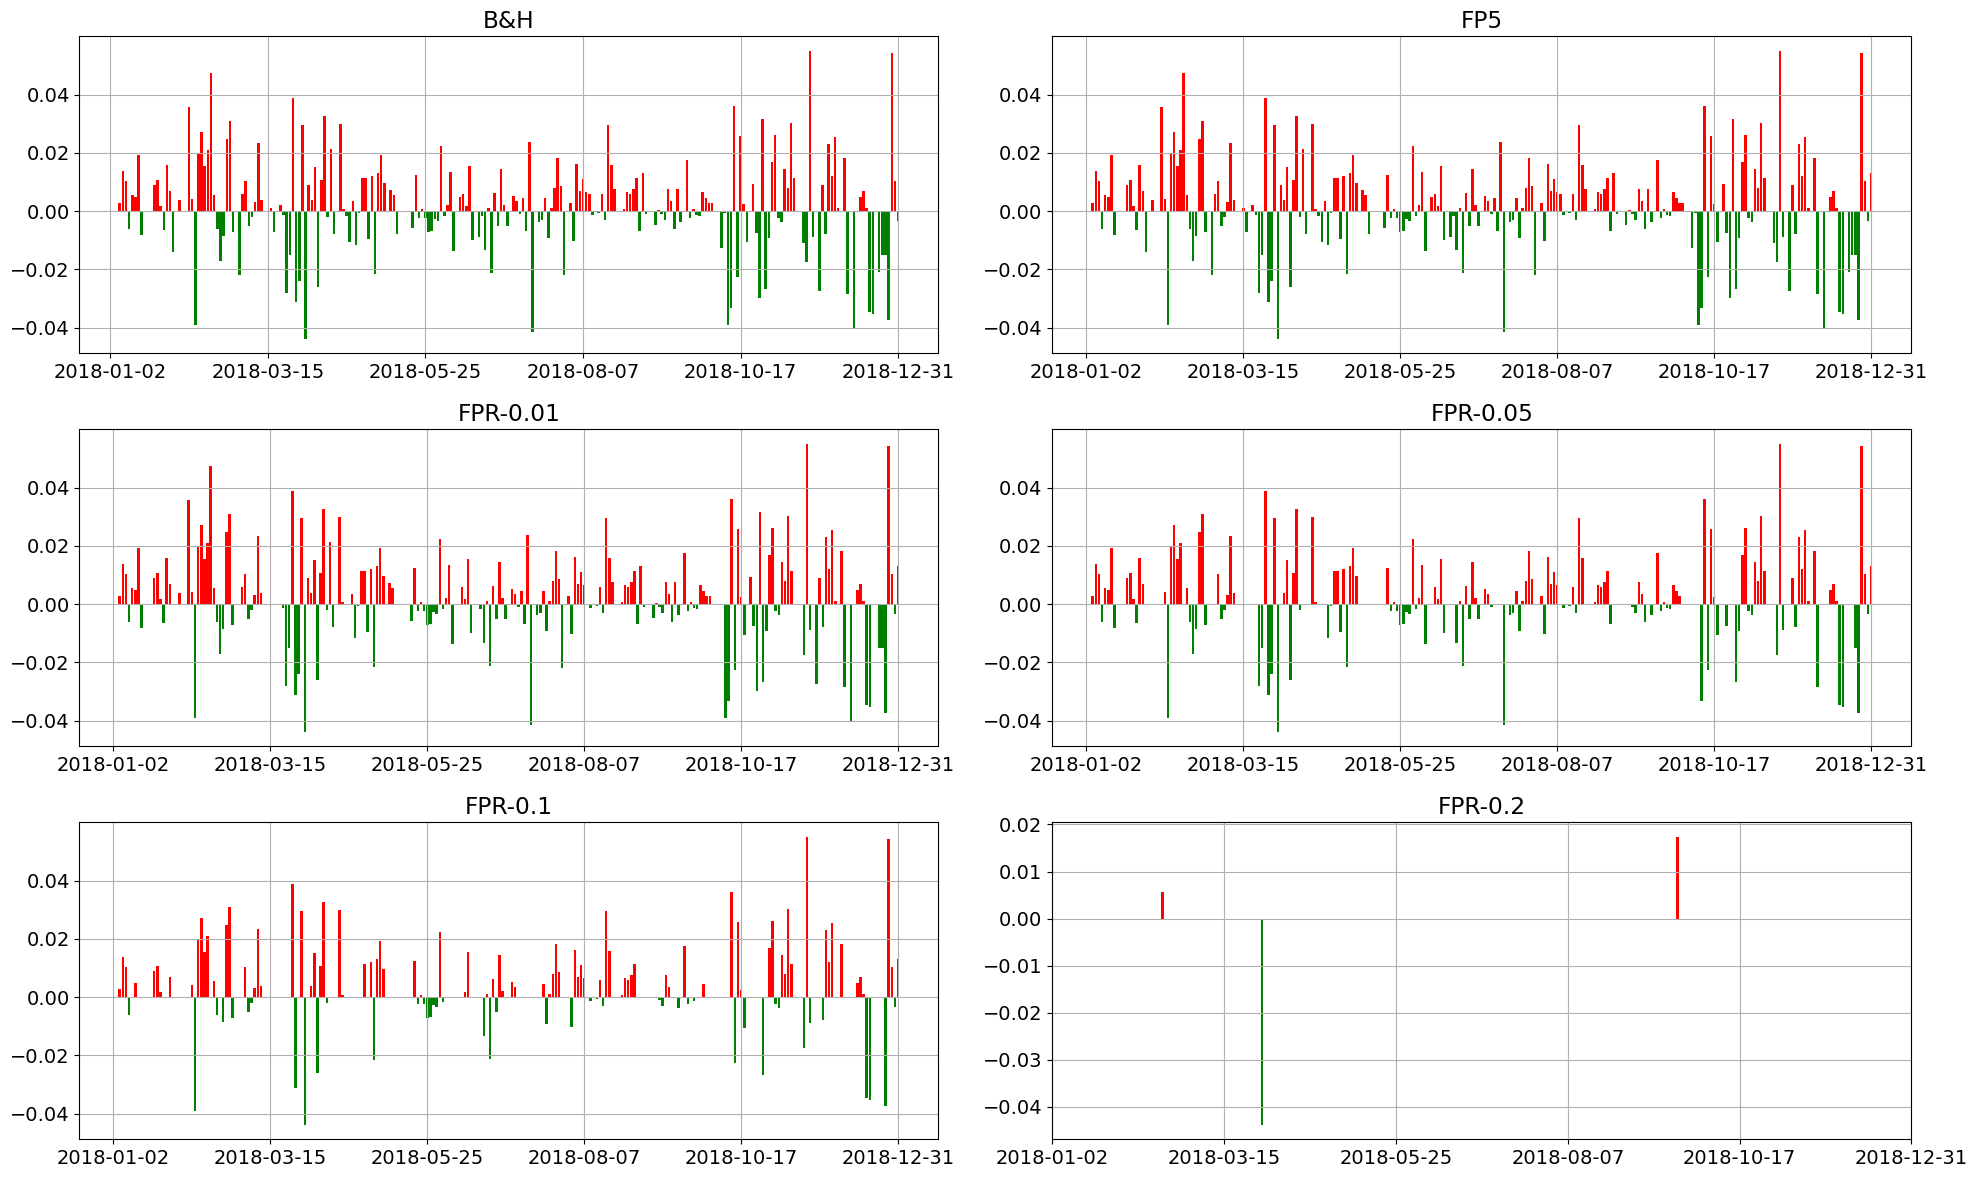

In [6]:
total_df = pd.read_csv("./ts-run-results/[exp2]returns.csv")

fig, axes = plt.subplots(3, 2, figsize=(20, 12))
axes = axes.reshape(-1)
cols = [col for col in list(total_df.columns) if "CSCO" in col]
for i, col in enumerate(cols[:]):
    tmp = total_df[col]
    tmp_up = tmp[tmp > 0]
    tmp_down = tmp[tmp < 0]
    axes[i].bar(list(tmp_up.index), tmp_up, color="red")
    axes[i].bar(list(tmp_down.index), tmp_down, color="green")
    axes[i].grid()
    length = list(tmp.index).__len__()
    indexes = [_len for _len in range(0, length+1, 50)]
    dates = [list(total_df["date"])[_len] for _len in indexes]
    axes[i].set_xticks(indexes, dates)
    axes[i].set_title("-".join(col.split("-")[1:]))


plt.tight_layout()
plt.savefig("./pictures/3-experiment2-CSCO-daily-return.png")
plt.show()

# NOTE 计算各类指标

In [19]:
results_df = pd.concat(results, axis=1)
ls = []
for symbol in symbols:
    
    results_df = results_df.rename({
        f"{symbol}-profit-0": f"{symbol}-FP5",
        f"{symbol}-regularized-0.01": f"{symbol}-FPR-0.01",
        f"{symbol}-regularized-0.05": f"{symbol}-FPR-0.05",
        f"{symbol}-regularized-0.1": f"{symbol}-FPR-0.1",
        f"{symbol}-regularized-0.2": f"{symbol}-FPR-0.2",
    }, axis=1)
    cols = [col for col in results_df.columns if symbol in col]
    tmp = results_df[cols]
    # cols.remove(f"{symbol}-FP5")
    # cols.insert(3, f"{symbol}-FP5")
    # tmp = tmp[cols]
    ls.append(tmp)

results_df = pd.concat(ls, axis=1)
# results_df.to_csv(f"./ts-run-results/[exp2]returns的各类指标.csv")
results_df

,CSCO-B&H,CSCO-FP5,CSCO-FPR-0.01,CSCO-FPR-0.05,CSCO-FPR-0.1,CSCO-FPR-0.2
sortino_test,0.925596,2.002347,2.291477,3.083661,4.521199,0.000000
sharpe_test,0.660608,1.444751,1.658316,2.180672,3.006375,0.000000
risk_test,0.263742,0.244155,0.240020,0.217392,0.192852,0.047948
mdd_test,0.174759,0.179385,0.179385,0.131673,0.103995,0.044120
downrisk_test,0.188235,0.176108,0.173149,0.153106,0.125418,0.044712
cumreturn_test,0.148917,0.380760,0.446330,0.562874,0.732380,0.000000


In [93]:
cols = list(filter(lambda x: "CSCO" in x, results_df.columns))
results_df[cols]

,CSCO-B&H,CSCO-FP5,CSCO-FPR-0.01,CSCO-FPR-0.05,CSCO-FPR-0.1,CSCO-FPR-0.2
sortino_test,0.925596,2.031148,2.323558,3.112911,4.574572,0.000000
sharpe_test,0.660608,1.467095,1.682880,2.205786,3.042705,0.000000
risk_test,0.263742,0.244096,0.239992,0.217359,0.192864,0.047917
mdd_test,0.174759,0.178892,0.178892,0.131325,0.103816,0.043833
downrisk_test,0.188235,0.176289,0.173190,0.153171,0.125362,0.000000
cumreturn_test,0.148917,0.388237,0.452027,0.572123,0.744638,0.000000


# NOTE 画累计收益图

In [76]:
dates = list(bhs[0].index)
dates_ls = []
dates_index = []
for i in range(6):
    dates_index.append(0 + 42 * i)
    dates_ls.append(dates[0 + 42*i])
dates_ls.append("2018-12-31")
dates_index.append(len(dates))
dates_ls

['2018-01-02',
 '2018-03-05',
 '2018-05-03',
 '2018-07-03',
 '2018-08-31',
 '2018-10-31',
 '2018-12-31']

In [20]:
dates_ls = ['2018-01-01',
 '2018-03-05',
 '2018-05-03',
 '2018-07-03',
 '2018-08-31',
 '2018-10-31',
 '2018-12-31']
dates_index = [42 * i for i in range(7)]

symbols = os.listdir("./Data/")[:10]
results_cumreturn2 = pd.read_csv("./ts-run-results/[exp2]cumreturns.csv")
results_cumreturn2 

,date,AAPL-B&H,AAPL-FP5,AAPL-FPR-0.01,AAPL-FPR-0.05,AAPL-FPR-0.1,AAPL-FPR-0.2,AMGN-B&H,AMGN-FP5,AMGN-FPR-0.01,...,DIS-FPR-0.01,DIS-FPR-0.05,DIS-FPR-0.1,DIS-FPR-0.2,GS-B&H,GS-FP5,GS-FPR-0.01,GS-FPR-0.05,GS-FPR-0.1,GS-FPR-0.2
0,2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2018-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,2018-01-04,-0.000174,0.004645,0.004645,0.004645,0.004645,0.0,0.018870,-0.004214,-0.004214,...,-0.000445,0.000000,0.0,0.0,-0.009309,0.000000,0.000000,0.0,0.0,0.0
3,2018-01-05,0.004470,0.016083,0.016083,0.016083,0.016083,0.0,0.014576,0.001719,0.001719,...,-0.000445,0.000000,0.0,0.0,0.004537,-0.005101,-0.005101,0.0,0.0,0.0
4,2018-01-08,0.015906,0.012309,0.012309,0.012309,0.012309,0.0,0.020621,0.001442,0.001442,...,-0.000445,0.000000,0.0,0.0,-0.000587,-0.005101,-0.005101,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2018-12-24,-0.111849,0.453507,0.471681,0.622789,0.377371,0.0,0.048053,0.690603,0.398815,...,0.393477,0.218422,0.0,0.0,-0.365375,0.461070,0.392820,0.0,0.0,0.0
247,2018-12-26,-0.134829,0.555865,0.575318,0.737068,0.450723,0.0,0.037526,0.780250,0.470903,...,0.469573,0.218422,0.0,0.0,-0.380046,0.522559,0.451437,0.0,0.0,0.0
248,2018-12-27,-0.073902,0.545768,0.565095,0.725795,0.441309,0.0,0.092543,0.803657,0.490242,...,0.479154,0.226366,0.0,0.0,-0.353955,0.545734,0.473530,0.0,0.0,0.0
249,2018-12-28,-0.079912,0.546560,0.565897,0.726679,0.441309,0.0,0.106908,0.807447,0.491807,...,0.489985,0.229411,0.0,0.0,-0.344121,0.523494,0.461686,0.0,0.0,0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


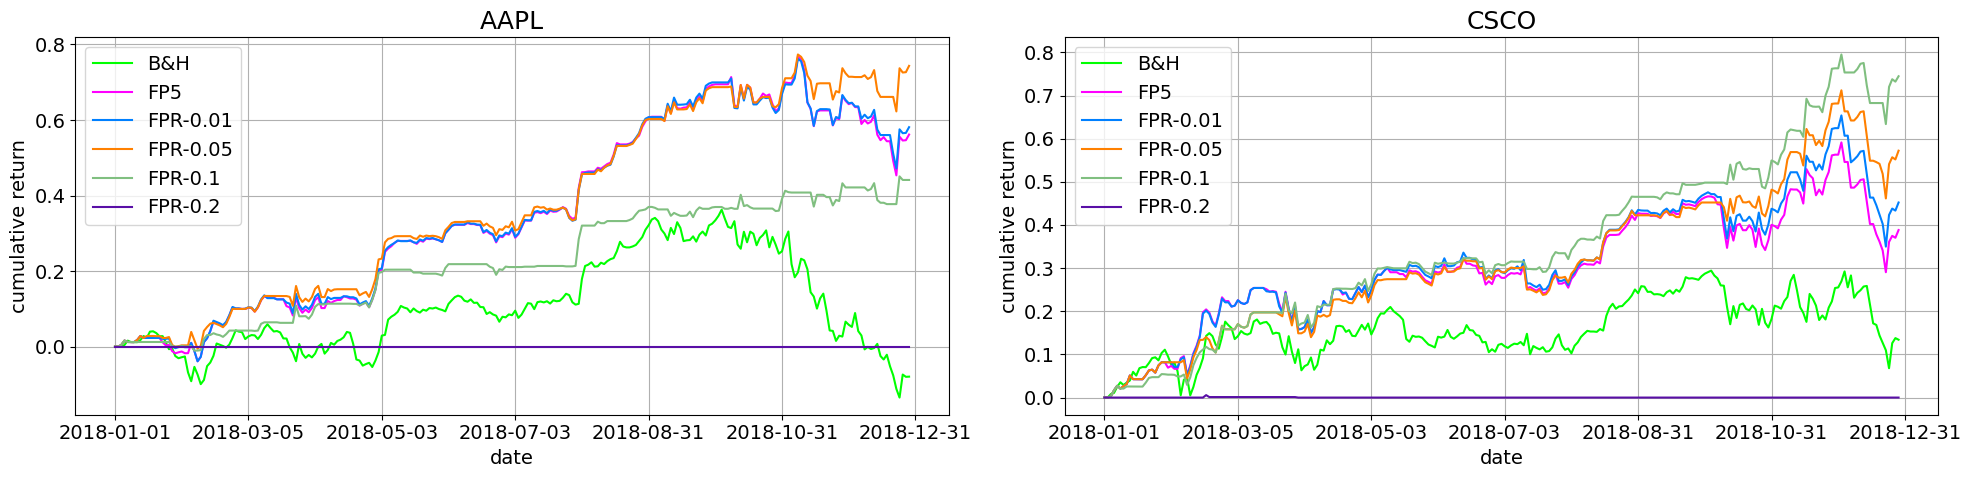

In [25]:
colors = [
    (0.0, 1.0, 0.0),
    (1.0, 0.0, 1.0),
    (0.0, 0.5, 1.0),
    (1.0, 0.5, 0.0),
    (0.5, 0.75, 0.5),
    (0.35, 0.06, 0.65)
]

names = ["B&H",	"FP5", "FPR-0.01", "FPR-0.05", "FPR-0.1", "FPR-0.2"]
# fig, axes = plt.subplots(5, 2, figsize=(20, 25))
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = axes.reshape(-1)
symbols = ["AAPL", "CSCO"]
for i, symbol in enumerate(symbols):
    cols = [col for col in results_cumreturn2.columns if symbol in col]
    tmp = results_cumreturn2[cols]
    for j, col in enumerate(cols):
        axes[i].plot(tmp[col], label=names[j], color=colors[j])
    max_value = np.max(tmp.max())
    axes[i].set_xticks(dates_index, dates_ls, fontsize=14)
    axes[i].set_title(symbol, fontsize=18)
    axes[i].set_xlabel("date", fontsize=14)
    axes[i].set_ylabel("cumulative return", fontsize=14)
    axes[i].legend()
    axes[i].grid()


plt.tight_layout()
# plt.savefig("./pictures/3-experiment2-cumreturn.eps")
plt.savefig("./pictures/3-experiment2-cumreturn-part.eps")
plt.show()

# NOTE 转latex table

In [26]:
import pandas as pd

results_df = pd.read_csv(f"./ts-run-results/[exp2]returns的各类指标.csv", index_col=[0])
cols = list(results_df.columns)
symbols = []
for col in cols:
    symbols.append(col.split("-")[0])

symbols = sorted(list(set(symbols)))
symbols

['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS']

In [37]:
def find(symbol):
    cols = [col for col in results_df.columns if symbol in col]
    tmp = results_df[cols]
    cols = ["-".join(col.split("-")[1:]) for col in list(tmp.columns)]
    tmp.columns = cols
    tmp = tmp.T
    cols = [col.split("_")[0] for col in list(tmp.columns)]
    tmp.columns = cols
    tmp = tmp.T[["B&H", "FP5", "FPR-0.01", "FPR-0.05", "FPR-0.1", "FPR-0.2"]].T
    tmp.columns = ["STR", "SR", "Risk", "MDD", "DR", "CR"]
    tmp = tmp[["CR", "STR", "SR", "MDD", "Risk", "DR"]]
    return tmp

In [39]:
ls = []
for symbol in symbols:
    tmp = find(symbol)
    tmp["symbol"] = symbol
    tmp = tmp.reset_index()
    tmp = tmp.set_index(["symbol", "index"])
    ls.append(tmp)
res_df = pd.concat(ls)
res_df = res_df.round(6)
res_df.to_csv("./ts-run-results/[exp2]合并的评价指标.csv")
res_df

CR       STR        SR       MDD      Risk        DR
symbol index                                                               
AAPL   B&H      -0.070543 -0.157630 -0.113196  0.365095  0.286281  0.205582
       FP5       0.561507  3.084893  2.048742  0.180061  0.228592  0.150923
       FPR-0.01  0.581032  3.202886  2.126199  0.166528  0.222813  0.141941
       FPR-0.05  0.743368  4.782367  2.770944  0.070665  0.206606  0.121930
       FPR-0.1   0.441309  5.113612  2.447544  0.045824  0.161326  0.073449
       FPR-0.2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
AMGN   B&H       0.132149  0.839055  0.645047  0.155024  0.236947  0.182160
       FP5       0.819169  6.939872  3.841376  0.066214  0.156475  0.084878
       FPR-0.01  0.497868  6.072886  3.066831  0.052172  0.134398  0.067641
       FPR-0.05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
       FPR-0.1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
       FPR-0.2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
AXP    B&H      -0.022560  0.034580  0.025758  0.207193  0.241258  0.179711
       FP5       0.352109  2.211787  1.562032  0.138731  0.210014  0.148177
       FPR-0.01  0.418248  2.567031  1.833648  0.126505  0.203828  0.142541
       FPR-0.05  0.579668  6.333317  3.195879  0.058616  0.141965  0.070628
       FPR-0.1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
       FPR-0.2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
BA     B&H       0.107767  0.735948  0.484992  0.246703  0.312972  0.206250
       FP5       0.133561  0.840894  0.559437  0.243786  0.310220  0.206344
       FPR-0.01  0.538285  2.706668  1.662718  0.139189  0.279452  0.180256
       FPR-0.05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
       FPR-0.1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
       FPR-0.2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
CAT    B&H      -0.172746 -0.575840 -0.421274  0.331021  0.325293  0.237978
       FP5      -0.174008 -0.582288 -0.425999  0.331021  0.323520  0.237978
       FPR-0.01 -0.145603 -0.442566 -0.325054  0.309057  0.322343  0.237821
       FPR-0.05  0.247686  3.113961  1.725338  0.068783  0.177102  0.098882
       FPR-0.1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
       FPR-0.2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
CRM    B&H       0.311847  1.312490  0.972739  0.247834  0.339607  0.251696
       FP5       0.607958  2.246033  1.670816  0.187175  0.316993  0.236674
       FPR-0.01  0.864225  3.367949  2.288696  0.155542  0.284641  0.192981
       FPR-0.05  0.662816  6.812838  3.248949  0.071634  0.167654  0.079801
       FPR-0.1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
       FPR-0.2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
CSCO   B&H       0.148917  0.925596  0.660608  0.174759  0.263742  0.188235
       FP5       0.388237  2.031148  1.467095  0.178892  0.244096  0.176289
       FPR-0.01  0.452027  2.323558  1.682880  0.178892  0.239992  0.173190
       FPR-0.05  0.572123  3.112911  2.205786  0.131325  0.217359  0.153171
       FPR-0.1   0.744638  4.574572  3.042705  0.103816  0.192864  0.125362
       FPR-0.2   0.000000  0.000000  0.000000  0.043833  0.047917  0.000000
CVX    B&H      -0.114382 -0.533830 -0.385494  0.214923  0.240864  0.173935
       FP5       0.370593  2.556274  1.698777  0.091626  0.197816  0.131694
       FPR-0.01  0.422626  3.164914  2.030446  0.090893  0.182857  0.117493
       FPR-0.05  0.156116  5.049713  1.989154  0.026638  0.074815  0.029395
       FPR-0.1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
       FPR-0.2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
DIS    B&H      -0.003678  0.119107  0.085348  0.149467  0.205959  0.147583
       FP5       0.483939  4.296998  2.691300  0.061152  0.151027  0.094744
       FPR-0.01  0.522618  5.357711  3.067373  0.045399  0.142835  0.08

In [40]:
def find(symbol):
    cols = [col for col in results_df.columns if symbol in col]
    tmp = results_df[cols]
    cols = ["-".join(col.split("-")[1:]) for col in list(tmp.columns)]
    tmp.columns = cols
    tmp = tmp.T
    cols = [col.split("_")[0] for col in list(tmp.columns)]
    tmp.columns = cols
    return tmp

In [41]:
def convert_latex(symbol, _df):
    template = "\\begin{table}[H]\n" + \
        "    \\label{table:" + symbol + "}\n" + \
        "    \\caption{" + symbol + "}\n" + \
        "    \\begin{tabular}{l c c c c c c}\n" + \
        "    \\hline\n" + \
        "                     & sortino & sharpe &	risk &  mdd    &  downrisk &	cumreturn     \\\ \n" + \
        "    \\hline\n" + \
        f"    B\\&H	          &  {_df['sortino'].iloc[0]:.4f} & {_df['sharpe'].iloc[0]:.4f}	& {_df['risk'].iloc[0]:.4f} &  {_df['mdd'].iloc[0]:.4f} &  {_df['downrisk'].iloc[0]:.4f}   & 	{_df['cumreturn'].iloc[0]:.4f}        \\\ \n" + \
        f"    FP5	          &  {_df['sortino'].iloc[1]:.4f} & {_df['sharpe'].iloc[1]:.4f}	& {_df['risk'].iloc[1]:.4f} & 	{_df['mdd'].iloc[1]:.4f} &  {_df['downrisk'].iloc[1]:.4f}   & 	{_df['cumreturn'].iloc[1]:.4f}        \\\ \n" + \
        f"    FPR-0.01             &	{_df['sortino'].iloc[2]:.4f} & {_df['sharpe'].iloc[2]:.4f}	& {_df['risk'].iloc[2]:.4f} & 	{_df['mdd'].iloc[2]:.4f} &  {_df['downrisk'].iloc[2]:.4f}   & 	{_df['cumreturn'].iloc[2]:.4f}        \\\ \n" + \
        f"    FPR-0.05             &  {_df['sortino'].iloc[3]:.4f} & {_df['sharpe'].iloc[3]:.4f}	& {_df['risk'].iloc[3]:.4f} & 	{_df['mdd'].iloc[3]:.4f} &  {_df['downrisk'].iloc[3]:.4f}   & 	{_df['cumreturn'].iloc[3]:.4f}        \\\ \n" + \
        f"    FPR-0.1	          &  {_df['sortino'].iloc[4]:.4f} & {_df['sharpe'].iloc[4]:.4f}	& {_df['risk'].iloc[4]:.4f} & 	{_df['mdd'].iloc[4]:.4f} &  {_df['downrisk'].iloc[4]:.4f}   & 	{_df['cumreturn'].iloc[4]:.4f}        \\\ \n" + \
        f"    FPR-0.2	          &  {_df['sortino'].iloc[5]:.4f} & {_df['sharpe'].iloc[5]:.4f}	& {_df['risk'].iloc[5]:.4f} & 	{_df['mdd'].iloc[5]:.4f} &  {_df['downrisk'].iloc[5]:.4f}   & 	{_df['cumreturn'].iloc[5]:.4f}        \\\ \n" + \
        "    \hline\n" + \
        "\\end{tabular}\n" + \
    "\\end{table}\n"
    print(template)

In [43]:
for symbol in symbols[-1:]:
    convert_latex(symbol, find(symbol))

\begin{table}[H]
    \label{table:GS}
    \caption{GS}
    \begin{tabular}{l c c c c c c}
    \hline
                     & sortino & sharpe &	risk &  mdd    &  downrisk &	cumreturn     \\ 
    \hline
    B\&H	          &  -2.0284 & -1.4853	& 0.2560 &  0.4218 &  0.1874   & 	-0.3376        \\ 
    FP5	          &  4.1345 & 2.6151	& 0.1779 & 	0.0998 &  0.1111   & 	0.5593        \\ 
    FPR-0.01             &	4.5451 & 2.6257	& 0.1490 & 	0.0969 &  0.0835   & 	0.4632        \\ 
    FPR-0.05             &  0.0000 & 0.0000	& 0.0000 & 	0.0000 &  0.0000   & 	0.0000        \\ 
    FPR-0.1	          &  0.0000 & 0.0000	& 0.0000 & 	0.0000 &  0.0000   & 	0.0000        \\ 
    FPR-0.2	          &  0.0000 & 0.0000	& 0.0000 & 	0.0000 &  0.0000   & 	0.0000        \\ 
    \hline
\end{tabular}
\end{table}

